In [1]:
import pandas as pd
import numpy as np
import itertools
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import time
import tqdm

ROOT_DIR = os.getcwd()
DATA_DIR = '/Users/vivianyan/Desktop/Reinforcement-Learning/Project/RL-Movie-Rec-Sys/ml-100k'
STATE_SIZE = 10

In [2]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

# Load data

In [7]:
ratings_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'mod_ratings.csv'), 'r').readlines()]
ratings_df = pd.DataFrame(ratings_list[1:], columns = ['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['userId'] = ratings_df['userId'].apply(pd.to_numeric)
ratings_df['movieId'] = ratings_df['movieId'].apply(pd.to_numeric)
ratings_df['rating'] = ratings_df['rating'].astype(float)

movies_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'mod_movies.csv'),encoding='latin-1').readlines()]
movies_df = pd.DataFrame(movies_list[1:], columns = ['movieId', 'title', 'genres'])
movies_df['movieId'] = movies_df['movieId'].apply(pd.to_numeric)

users_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'users.csv'), 'r').readlines()]
users_df = pd.DataFrame(users_list[1:], columns=['userId', 'gender', 'age', 'occupation', 'zip'])

In [10]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list[1:]}
print(len(movies_list))
movies_df.head(5)

9743


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western',
        '(no genres listed)',
        'IMAX']

# Movie Genre Model
## Movie Genre dataframe

In [15]:
movies_genres_df = movies_df[['movieId', 'genres']]
movies_genres_df.head(5)

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy


In [ ]:
# map genres to index (int)
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

movies_genres_df['genres'] = movies_genres_df['genres'].map(lambda x : _split_and_index(x))
movies_genres_df.head(5)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_29068/1020614315.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_genres_df['genres'] = movies_genres_df['genres'].map(lambda x : _split_and_index(x))


,movieId,genres
0,1,"[1, 2, 3, 4, 8]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7, 13]"
4,5,[4]


In [ ]:
# check null
movies_genres_df.isnull().sum()

movieId    0
genres     0
dtype: int64

In [21]:
print(len(movies_genres_df['movieId']))
print(movies_genres_df['movieId'].nunique())

9742
9742


## Movie Genre embedding

In [38]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        self.m_g_fc = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        movie_input, genre_input = inputs
        memb = self.m_embedding(movie_input)
        gemb = self.g_embedding(genre_input)
        m_g = self.m_g_merge([memb, gemb])
        return self.m_g_fc(m_g)


## Batch generator

In [ ]:
movies_genres_dict = {m: g for m, g in zip(movies_genres_df["movieId"], movies_genres_df["genres"])}
movies_genres_dict[1]

[1, 2, 3, 4, 8]

In [26]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["movieId"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [27]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

## Train & save model weights

In [71]:
LEN_MOVIES = max(movies_genres_df["movieId"])+1
LEN_GENRES = len(genres)+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 50
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE

In [73]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ movie_embedding (Embedding)     │ (1, 100)               │    19,361,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ genre_embedding (Embedding)     │ (1, 100)               │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_genre_dot (Dot)           │ (1, 1)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,363,102 (73.86 MB)

 Trainable params: 19,363,102 (73.86 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [75]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [76]:
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

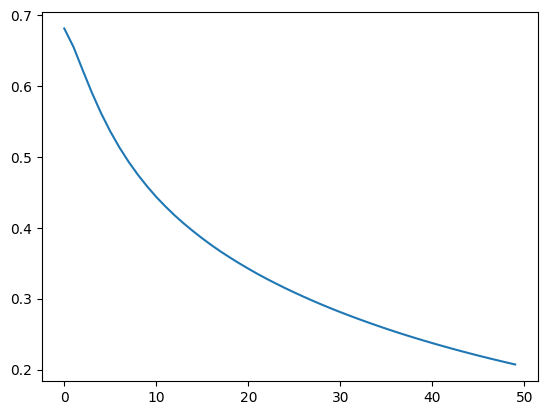

In [77]:
plt.plot(m_g_losses)

In [78]:
m_g_model.save_weights('/Users/vivianyan/Desktop/Reinforcement-Learning/Project/RL-Movie-Rec-Sys/DDPG/save_weights/m_g_model_weights.weights.h5')

# User Movie Model

## User Movie dataframe

In [22]:
user_movie_rating_df = ratings_df[['userId','movieId','rating']]
user_movie_rating_df.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [23]:
# check null
user_movie_rating_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [24]:
print('Unique users: ', user_movie_rating_df['userId'].nunique())
print('Unique movies: ', user_movie_rating_df['movieId'].nunique())

Unique users:  610
Unique movies:  9724


## User Movie embedding

In [55]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        user_input, movie_input = inputs
        uemb = self.u_embedding(user_input)
        m_u = self.m_u_merge([movie_input, uemb])
        return self.m_u_fc(m_u)


## Batch generator

In [28]:
index_names = user_movie_rating_df[user_movie_rating_df['rating']<4.0].index
user_movie_rating_df = user_movie_rating_df.drop(index_names)
user_movie_rating_df = user_movie_rating_df.drop('rating', axis=1)
u_m_pairs = user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[ 1,  1],
       [ 1,  3],
       [ 1,  6],
       [ 1, 47],
       [ 1, 50]])

In [30]:
positive_user_movie_dict = {u : [] for u in range(1, max(user_movie_rating_df['userId'])+1)}
for data in user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_29068/2067319221.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_user_movie_dict[data[1][0]].append(data[1][1])


[1,
 3,
 6,
 47,
 50,
 101,
 110,
 151,
 157,
 163,
 216,
 231,
 235,
 260,
 333,
 349,
 356,
 362,
 367,
 441,
 457,
 480,
 527,
 543,
 552,
 553,
 590,
 592,
 593,
 596,
 608,
 661,
 733,
 804,
 919,
 923,
 940,
 943,
 954,
 1023,
 1024,
 1025,
 1029,
 1031,
 1032,
 1042,
 1049,
 1060,
 1073,
 1080,
 1089,
 1090,
 1092,
 1097,
 1127,
 1136,
 1196,
 1197,
 1198,
 1206,
 1208,
 1210,
 1213,
 1214,
 1220,
 1222,
 1224,
 1226,
 1240,
 1256,
 1265,
 1270,
 1275,
 1278,
 1282,
 1291,
 1298,
 1348,
 1473,
 1500,
 1517,
 1552,
 1573,
 1587,
 1617,
 1620,
 1625,
 1732,
 1777,
 1793,
 1804,
 1805,
 1920,
 1927,
 1954,
 1967,
 2000,
 2005,
 2012,
 2018,
 2028,
 2033,
 2046,
 2048,
 2054,
 2058,
 2078,
 2090,
 2094,
 2096,
 2099,
 2105,
 2115,
 2116,
 2137,
 2139,
 2141,
 2143,
 2161,
 2174,
 2193,
 2268,
 2273,
 2291,
 2329,
 2353,
 2366,
 2387,
 2395,
 2406,
 2427,
 2450,
 2459,
 2470,
 2478,
 2492,
 2502,
 2529,
 2542,
 2571,
 2580,
 2596,
 2616,
 2628,
 2640,
 2641,
 2644,
 2648,
 2654,
 269

In [31]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(user_movie_rating_df['userId'])+1
    max_movie_id = max(user_movie_rating_df['movieId'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

## Train & save model weights

In [79]:
LEN_USERS = max(user_movie_rating_df['userId'])+1
MAX_EPOCH = 80
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 512

In [80]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (1, 100)               │        61,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_user_dot (Dot)            │ (1, 1)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,102 (238.68 KB)

 Trainable params: 61,102 (238.68 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [82]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [83]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

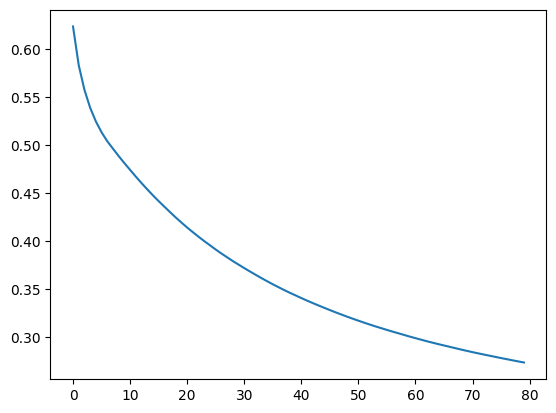

In [84]:
plt.plot(u_m_losses)

In [85]:
u_m_model.save_weights('/Users/vivianyan/Desktop/Reinforcement-Learning/Project/RL-Movie-Rec-Sys/DDPG/save_weights/u_m_model_weights.weights.h5')